In [83]:
import numpy as np
import stdatamodels.jwst.datamodels as dm
import matplotlib.pyplot as plt
import os

os.environ['CRDS_PATH'] = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/"
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

from glob import glob
import pandas as pd
from astropy.visualization import ZScaleInterval
from astropy.io import fits
from jwst.barshadow import BarShadowStep
from matplotlib import colormaps as cm
from matplotlib.colors import LogNorm

directory = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/TestSingleSlit/"

# Keep only one source for faster tests

In [ ]:
def keepOnlySource(model, srcid):
	slits = []
	for i in range(len(model.slits)):
		_ = model.slits.pop(0)
		if _.source_id == srcid:
			slits.append(_)

	for slit in slits:
		model.slits.append(slit)
	return model

In [ ]:
msa = fits.open(directory + "jw01345063001_01_msa.fits")

msa[2].data = msa[2].data[msa[2].data["source_id"] == 22800]
msa[3].data = msa[3].data[msa[3].data["source_id"] == 22800]

msa.writeto(directory + "jw01345063001_01_msa.fits", overwrite=True)


# Det 1 Stage

In [95]:
from jwst.pipeline import Spec2Pipeline, Spec3Pipeline, Detector1Pipeline

uncal_list = glob(directory + "*_uncal.fits")

for uncal in uncal_list:
	steps = {
                    'jump': {'expand_large_events': True,
                             # 1st flag groups after jump above DN threshold.
                             'after_jump_flag_dn1': 0,
                             # 1st flag groups after jump groups within
                             # specified time.
                             'after_jump_flag_time1': 0,
                             # 2nd flag groups after jump above DN threshold.
                             'after_jump_flag_dn2': 0,
                             # 2nd flag groups after jump groups within
                             # specified time.
                             'after_jump_flag_time2': 0,
                             # Minimum required area for the central saturation
                             # of snowballs.
                             'min_sat_area': 15.0,
                             # Minimum area to trigger large events processing.
                             'min_jump_area': 15.0,
                             # The expansion factor for the enclosing circles
                             # or ellipses.
                             'expand_factor': 20.0},
                }
	det1 = Detector1Pipeline(steps=steps)
	for step in det1.steps:
		getattr(det1, step).save_results = True
	det1.output_dir = directory + "Stage1/"
	det1.save_results = True
	det1.run(uncal)

2025-01-13 17:15:23,918 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-01-13 17:15:23,919 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-01-13 17:15:23,920 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-01-13 17:15:23,922 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-01-13 17:15:23,922 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2025-01-13 17:15:23,923 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2025-01-13 17:15:23,925 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2025-01-13 17:15:23,927 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2025-01-13 17:15:23,928 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-01-13 17:15:23,929 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-01-13 17:15

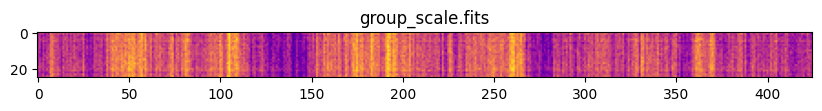

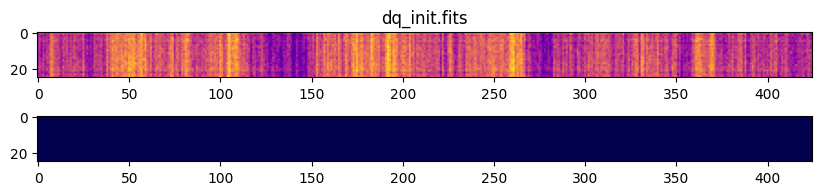

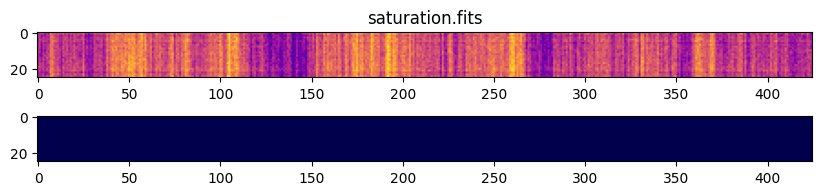

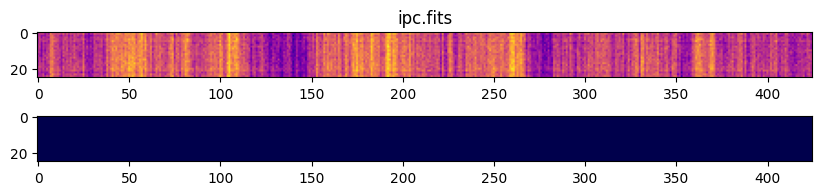

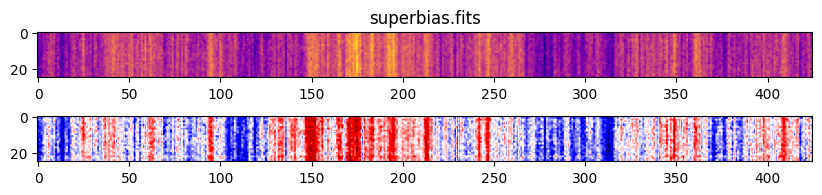

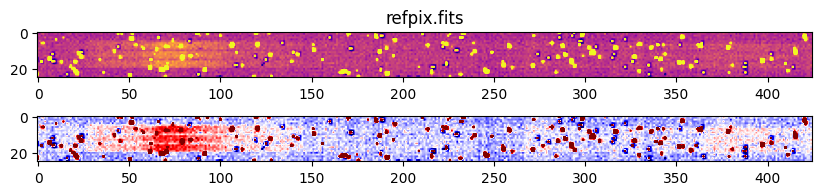

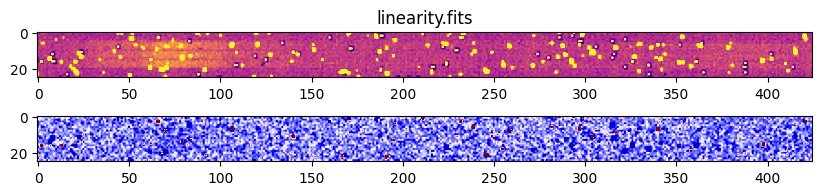

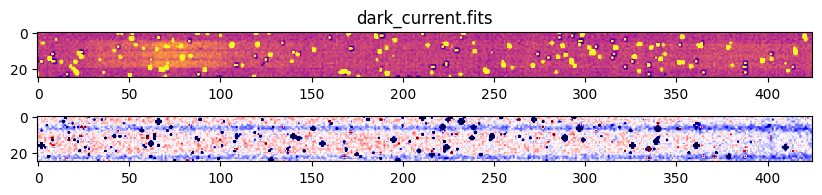

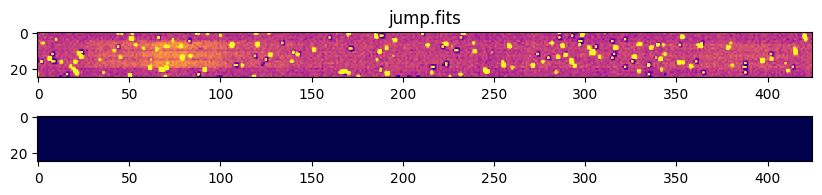

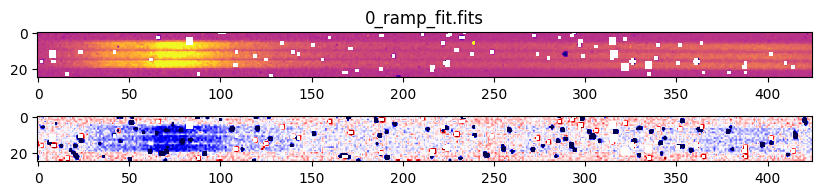

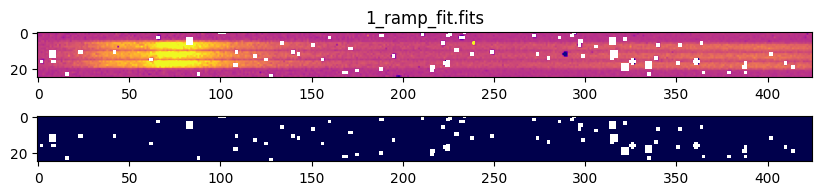

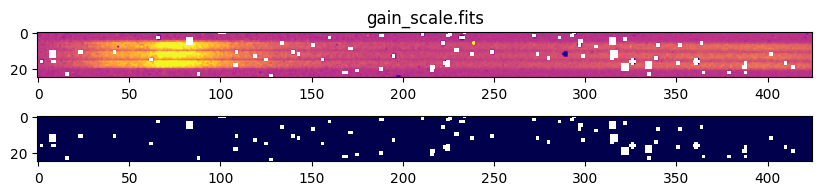

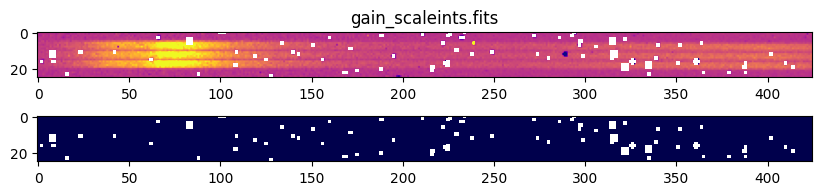

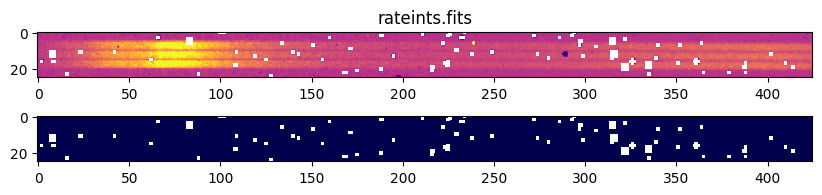

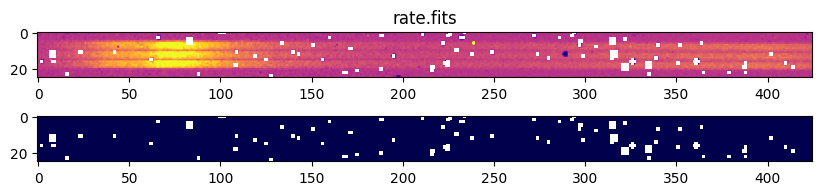

In [87]:
det1_files = glob(directory + "Stage1/*")
det1_files.sort(key=os.path.getmtime)
datalist = []

ylim = (1567, 1992)
xlim = (386, 411)

for file in det1_files:
	file = fits.open(file)

	if len(file[1].data.shape) == 2:
		data = file[1].data[xlim[0]:xlim[1], ylim[0]:ylim[1]]

	if len(file[1].data.shape) == 3:
		data = file[1].data[0, xlim[0]:xlim[1], ylim[0]:ylim[1]]

	if len(file[1].data.shape) == 4:
		data = file[1].data[0, 13, xlim[0]:xlim[1], ylim[0]:ylim[1]]

	z1,z2 = ZScaleInterval().get_limits(data)
	plt.figure(figsize=(10, 2))
	plt.subplot(211)
	plt.imshow(data, cmap="plasma", vmin=z1, vmax=z2)
	plt.title(os.path.basename(file.filename())[31:])

	if len(datalist) > 0:
		residual = data - datalist[-1]
		z1,z2 = ZScaleInterval().get_limits(residual)
		plt.subplot(212)
		plt.imshow(residual, cmap="seismic", vmin=z1, vmax=z2)

	plt.show()
	datalist.append(data)

	file.close()

In [88]:
from jwst.jump import JumpStep

dark = [_ for _ in det1_files if "dark_current" in _][0]
dark = dm.open(dark)

2025-01-13 17:06:48,285 - stpipe.JumpStep - INFO - JumpStep instance created.
2025-01-13 17:06:48,587 - stpipe.JumpStep - INFO - Step JumpStep running with args (<RampModel(1, 14, 2048, 2048) from jw01345063001_03101_00002_nrs1_dark_current.fits>,).
2025-01-13 17:06:48,590 - stpipe.JumpStep - INFO - Step JumpStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  rejection_threshold: 4.0
  three_group_rejection_threshold: 6.0
  four_group_rejection_threshold: 5.0
  maximum_cores: '1'
  flag_4_neighbors: True
  max_jump_to_flag_neighbors: 1000.0
  min_jump_to_flag_neighbors: 10.0
  after_jump_flag_dn1: 0
  after_jump_flag_time1: 0
  after_jump_flag_dn2: 0
  after_jump_flag_time2: 0
  expand_large_events: True
  min_sat_area: 15.0
  min_jump_area: 15.0
  expand_factor: 2.0
  use_ellipses

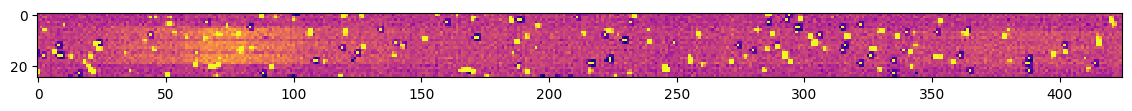

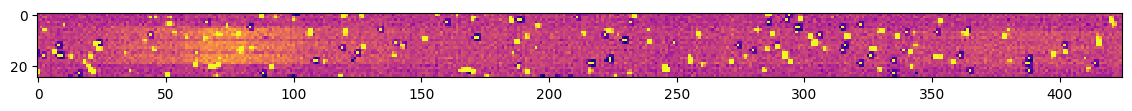

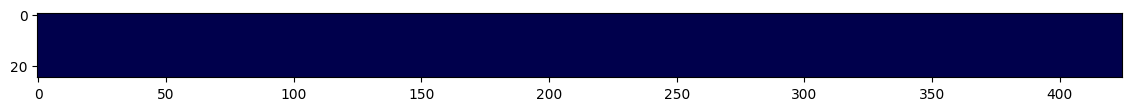

In [94]:
jump = JumpStep()
jump.expand_large_events = True
jump.after_jump_flag_dn1 = 0
jump.after_jump_flag_time1 = 0
jump.after_jump_flag_dn2 = 0
jump.after_jump_flag_time2 = 0
jump.min_sat_area = 15.0
jump.min_jump_area = 15.0
jump.expand_factor = 20.0
j = jump.run(dark)

plt.figure(figsize=(14, 2))
_ = dm.open([_ for _ in det1_files if "jump" in _][0])
data1 = _.data[0,13,xlim[0]:xlim[1], ylim[0]:ylim[1]]
z1,z2 = ZScaleInterval().get_limits(data1)
plt.imshow(data1, cmap="plasma", vmin=z1, vmax=z2, interpolation='none')
plt.show()

plt.figure(figsize=(14, 2))
data2 = j.data[0,13,xlim[0]:xlim[1], ylim[0]:ylim[1]]
z1,z2 = ZScaleInterval().get_limits(data2)
plt.imshow(data2, cmap="plasma", vmin=z1, vmax=z2, interpolation='none')
plt.show()

plt.figure(figsize=(14, 2))
data = data1 - data2
z1,z2 = ZScaleInterval().get_limits(data)
plt.imshow(data, cmap="seismic", vmin=z1, vmax=z2, interpolation='none')
plt.show()



# Treat both with and without subtraction

In [73]:
uncal_list = glob(directory + "*_uncal.fits")

for uncal in uncal_list:
	det1 = Detector1Pipeline()
	det1.output_dir = directory
	det1.save_results = True
	det1.run(uncal)

2025-01-13 16:40:17,763 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-01-13 16:40:17,764 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-01-13 16:40:17,765 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-01-13 16:40:17,766 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-01-13 16:40:17,767 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2025-01-13 16:40:17,769 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2025-01-13 16:40:17,770 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2025-01-13 16:40:17,771 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2025-01-13 16:40:17,772 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-01-13 16:40:17,773 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-01-13 16:40

In [103]:
asn_list = glob(directory + "*spec2*asn*")
for asn in asn_list:
	steps = {"bkg_subtract" : {"skip":True},
			 "flat_field" : {"save_interpolated_flat" : True}}
	spec2 = Spec2Pipeline(steps=steps)
	spec2.output_dir = directory + "NoSub/"
	spec2.save_results = True
	spec2.run(asn)

	spec2 = Spec2Pipeline()
	spec2.output_dir = directory + "Default/"
	spec2.save_results = True
	spec2.run(asn)

for folder in ["Default/", "NoSub/"]:
	asn = directory + folder + "jw01345-o063_20241001t101453_spec3_00001_asn.json"
	spec3 = Spec3Pipeline()
	spec3.output_dir = directory + folder
	spec3.save_results = True
	spec3.run(asn)

2025-01-13 18:06:42,669 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2025-01-13 18:06:42,670 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-01-13 18:06:42,671 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.
2025-01-13 18:06:42,672 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2025-01-13 18:06:42,673 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2025-01-13 18:06:42,674 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-01-13 18:06:42,675 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2025-01-13 18:06:42,675 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2025-01-13 18:06:42,677 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2025-01-13 18:06:42,677 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INF

# Read output logs

In [ ]:
def removeDate(input_file):
	with open(input_file, "r") as file:
		lines = file.readlines()

	# Process the lines
	processed_lines = []
	for line in lines:
		if "stpipe." in line:
			truncated_line = line.split("stpipe.", 1)[1]  # Keep everything after "stpipe."
			truncated_line = "stpipe." + truncated_line  # Add "stpipe." back at the beginning
			processed_lines.append(truncated_line)
		else:
			processed_lines.append(line)  # Keep lines unchanged if "stpipe." not found

	# Write the processed lines to a new file
	with open(input_file, "w") as file:
		file.writelines(processed_lines)

removeDate(directory+"nosub.log")
removeDate(directory+"default.log")


In [ ]:
import difflib

with open(directory+"nosub.log", "r") as f1, open(directory+"default.log", "r") as f2:
	lines1 = f1.readlines()
	lines2 = f2.readlines()

# Use difflib to compare the lines
differ = difflib.unified_diff(lines1, lines2, lineterm="", n=0)

# Print the differences
print("Differences between the files:")
for line in differ:
	if "@@" in line:
		print("\n")
	print(line.strip())


# Compare both stage 2 cal files

In [ ]:
nosub = dm.open(directory + "NoSub/jw01345063001_03101_00001_nrs1_s2d.fits").slits[0].data
default = dm.open(directory + "Default/jw01345063001_03101_00001_nrs1_s2d.fits").slits[0].data

print(np.nanmin(nosub), np.nanmax(nosub))
print(np.nanmin(default), np.nanmax(default))

plt.figure(figsize=(12,2))
residual = nosub - default
z1, z2 = ZScaleInterval().get_limits(residual)
plt.imshow(residual, origin="lower", vmin=z1, vmax=z2)
plt.show()

plt.figure(figsize=(12,2))
z1, z2 = ZScaleInterval().get_limits(nosub)
plt.imshow(nosub, origin="lower", vmin=z1, vmax=z2)
plt.show()

# Manual background subtraction

In [ ]:
rate_list = glob(directory + "NoSub/*nrs1*cal.fits")
rate_list = [dm.open(_).slits[0].data for _ in rate_list]

%matplotlib Qt5Agg

In [ ]:
from matplotlib.widgets import Slider

fig, ax = plt.subplots(figsize=(14,3))


# Slider
ax_slider1 = plt.axes((0.2, 0.05, 0.6, 0.03))
slider1 = Slider(ax_slider1, '1', -1, 1, valinit=0, valstep=0.01)
ax_slider2 = plt.axes((0.2, 0.02, 0.6, 0.03))
slider2 = Slider(ax_slider2, '2', -1, 1, valinit=0, valstep=0.01)


def update(val):
	c1 = slider1.val
	c2 = slider2.val

	img = rate_list[2] - c2*((1-c1)/2*rate_list[0] + (1+c1)/2*rate_list[1])
	z1, z2 = ZScaleInterval().get_limits(img)

	ax.imshow(img, origin='lower', interpolation='none', vmin=z1, vmax=z2)
	xlim = ax.get_xlim()
	ylim = ax.get_ylim()
	ax.clear()
	ax.imshow(img, origin='lower', interpolation='none', vmin=z1, vmax=z2)

#	xlim = (1567,1992)
#	ylim = (386,411)
	ax.set_ylim(*ylim)
	ax.set_xlim(*xlim)
update(0)

# Attach the update function to the slider
slider1.on_changed(update)
slider2.on_changed(update)

plt.show()

# Analyse slit image

In [ ]:
cal_list = glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/*_cal.fits")
cal_list = [dm.open(_) for _ in cal_list]

In [ ]:
x = np.array([])
wave = np.array([])
f = np.array([])

for cal in cal_list:
	for i, slit in enumerate(cal.slits):
		Y,X = np.indices(slit.data.shape)
		_ ,slit_frame_x, wavelength = slit.meta.wcs.transform("detector", "slit_frame", X, Y)
		slit_frame_x = slit_frame_x.ravel()
		wavelength = wavelength.ravel()
		data = slit.data.ravel()

		mask = (np.isfinite(slit_frame_x)) & (np.isfinite(wavelength)) & (np.isfinite(data))
		slit_frame_x, wavelength, data = data[mask], wavelength[mask], data[mask]

		x = np.append(x, slit_frame_x)
		wave = np.append(wave, wavelength)
		f = np.append(f, data)

		plt.figure(figsize=(18,14))
		plt.subplot(221)
		plt.hexbin(wavelength.ravel(), slit_frame_x.ravel(), C=slit.data.ravel(), gridsize=100, cmap="plasma", bins=None, norm=LogNorm())
		plt.subplot(222)
		plt.imshow(slit.data, origin='lower', interpolation='none', cmap="plasma")
		plt.title(i)
		plt.colorbar()

		_ ,slit_frame_x, wavelength = slit.meta.wcs.transform("detector", "slit_frame", X, Y)
		plt.subplot(223)
		plt.imshow(slit_frame_x, origin='lower', interpolation='none', cmap="seismic")
		plt.colorbar()
		plt.subplot(224)
		plt.imshow(wavelength, origin='lower', interpolation='none', cmap="plasma")
		plt.colorbar()
		plt.show()

	break

In [ ]:
plt.figure(figsize=(12,12))

plt.hexbin(wave, x, C=f, gridsize=100, cmap="plasma", bins=None, norm=LogNorm())
plt.axis((wave.min(), wave.max(), x.min(), x.max()))

cb = plt.colorbar()
plt.show()

In [ ]:
slit = cal_list[0].slits[17]

print(slit.meta.wcs.available_frames)

plt.figure(figsize=(12,4))
plt.imshow(slit.data, origin='lower', interpolation='none', cmap="plasma")
plt.show()

Y,X = np.indices(slit.data.shape)
for frame in slit.meta.wcs.available_frames:
	if frame == "detector":
		continue
	trans = slit.meta.wcs.transform("detector", frame, X, Y)
	for i,_ in enumerate(trans):
		plt.figure(figsize=(12,4))
		plt.imshow(_, origin='lower', interpolation='none', cmap="plasma")
		plt.title(f"{frame} ,  {i}")
		plt.colorbar()
		plt.show()

# Effect of barshadow

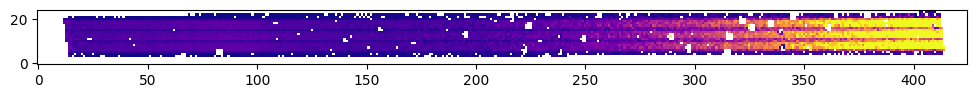

2025-01-13 16:44:27,423 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.
2025-01-13 16:44:27,697 - stpipe.BarShadowStep - INFO - Step BarShadowStep running with args (<MultiSlitModel from jw01345063001_03101_00001_nrs1_cal.fits>,).
2025-01-13 16:44:27,698 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  inverse: False
  source_type: UNIFORM
2025-01-13 16:44:27,709 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/references/jwst/nirspec/jwst_nirspec_barshadow_0006.fits
2025-01-13 16:44:27,774 - stpipe.BarShadowStep - INFO - Working on slitlet 200
2025-01-13 16:44:27,812 - stpipe.BarShadowStep - INFO - Results used CRDS context: jwst_1303.pmap

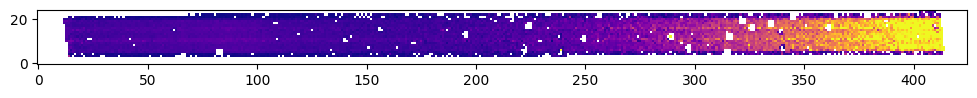

In [76]:
path = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/TestSingleSlit/NoSub/jw01345063001_03101_00001_nrs1_cal.fits"
s2d = dm.open(path)

plt.figure(figsize=(12,4))
data = s2d.slits[0].data
data[data<0] = np.nan
z1, z2 = ZScaleInterval().get_limits(s2d.slits[0].data)
plt.imshow(s2d.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.show()

barshadow = BarShadowStep()
barshadow.source_type = "UNIFORM"
bs2d = barshadow.run(s2d)

plt.figure(figsize=(12,4))
z1, z2 = ZScaleInterval().get_limits(bs2d.slits[0].data)
plt.imshow(bs2d.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.show()

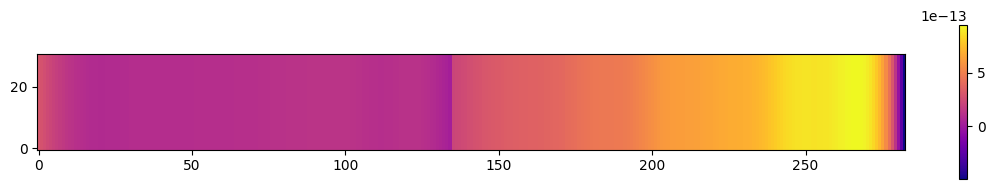

2025-01-13 18:02:26,594 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.
2025-01-13 18:02:26,602 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.
2025-01-13 18:02:26,929 - stpipe.BarShadowStep - INFO - Step BarShadowStep running with args (<MultiSlitModel from jw01345063001_03101_00001_nrs1_cal.fits>,).
2025-01-13 18:02:26,930 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  inverse: True
  source_type: UNIFORM
2025-01-13 18:02:26,942 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/references/jwst/nirspec/jwst_nirspec_barshadow_0006.fits
2025-01-13 18:02:26,970 - stpipe.BarShadowStep - INFO - Working on slitlet 145
2025-01-13

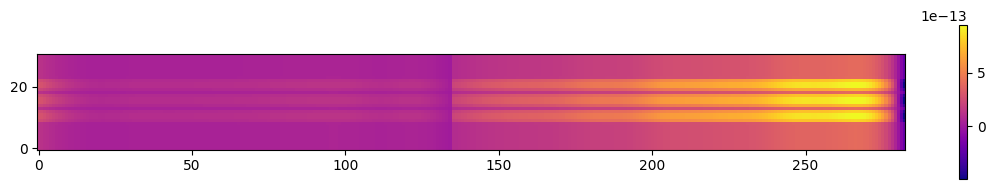

2025-01-13 18:02:27,047 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2025-01-13 18:02:27,058 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2025-01-13 18:02:27,364 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from jw01345063001_03101_00001_nrs1_cal.fits>,).
2025-01-13 18:02:27,366 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  inverse: True
  source_type: EXTENDED
  user_slit_loc: None
2025-01-13 18:02:27,380 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits
2025-01-13 18:02:27,399 - stpipe.PathLossStep - INFO - Input exposure type is

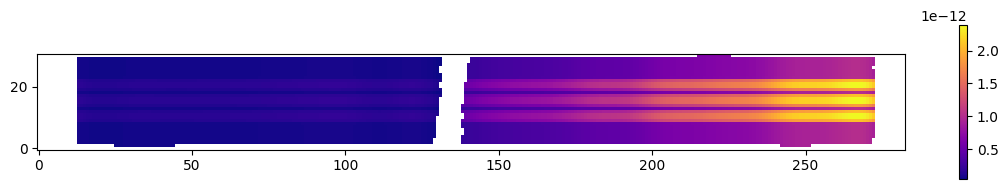

2025-01-13 18:02:27,475 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2025-01-13 18:02:27,483 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2025-01-13 18:02:27,776 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw01345063001_03101_00001_nrs1_cal.fits>,).
2025-01-13 18:02:27,780 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_interpolated_flat: False
  user_supplied_flat: None
  inverse: True
2025-01-13 18:02:27,808 - stpipe.FlatFieldStep - INFO - No reference found for type FLAT
2025-01-13 18:02:27,846 - stpipe.FlatFieldStep - INFO - Using FFLAT reference file: /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/references/jwst/nirspec/

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [102]:
from stdatamodels.jwst.datamodels import MultiSlitModel
from jwst.flatfield import FlatFieldStep
from jwst.pathloss import PathLossStep
from jwst.barshadow import BarShadowStep

_ = dm.open("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/Final/BNBG/jw01345-o063_s000004611_nirspec_clear-prism_bkg-BNBG.fits")

bkg = s2d.copy()
bkg.slits[0] = _

plt.figure(figsize=(14,2))
z1, z2 = ZScaleInterval().get_limits(bkg.slits[0].data)
plt.imshow(bkg.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.colorbar()
plt.show()

bkg = BarShadowStep().call(bkg, inverse=True, source_type="UNIFORM")

plt.figure(figsize=(14,2))
z1, z2 = ZScaleInterval().get_limits(bkg.slits[0].data)
plt.imshow(bkg.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.colorbar()
plt.show()

bkg = PathLossStep().call(bkg, inverse=True, source_type="EXTENDED")

plt.figure(figsize=(14,2))
z1, z2 = ZScaleInterval().get_limits(bkg.slits[0].data)
plt.imshow(bkg.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.colorbar()
plt.show()

bkg = FlatFieldStep().call(bkg, inverse=True)

plt.figure(figsize=(14,2))
z1, z2 = ZScaleInterval().get_limits(bkg.slits[0].data)
plt.imshow(bkg.slits[0].data, origin='lower', interpolation='none', cmap="plasma", vmin=z1, vmax=z2)
plt.colorbar()
plt.show()